# Dati longitudinali  {#sec-longitudinal-data}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(kableExtra, lme4)

Caricamento dei namespace richiesti: pacman



## Introduzione

L'obiettivo di questo capitolo è esaminare come è possibile estendere i modelli SEM per adattarli alle particolarità dei dati longitudinali. Per semplificare, cominciamo concentrandoci su due misurazioni temporali consecutive.

## Misurare il Cambiamento

Il modo più semplice per valutare il cambiamento individuale tra due momenti temporali consiste nel calcolare la differenza tra i punteggi ottenuti nelle due occasioni. Tuttavia, questa strategia ha un limite significativo: non disponiamo del punteggio "vero" dell’individuo in ciascun momento, ma solo di una misura influenzata dall'errore di misurazione. L'errore di misurazione può ridurre notevolmente la precisione delle stime sulle differenze individuali, compromettendo l'interpretazione del cambiamento.

Per superare questo problema negli studi longitudinali, vengono impiegati i **modelli di crescita latente** (Latent Growth Models, LGM), appartenenti alla famiglia dei modelli a equazioni strutturali (SEM). Questi modelli permettono di stimare traiettorie di cambiamento per ciascun individuo, separando le componenti latenti dal rumore delle misurazioni. 

### Componenti del Modello di Crescita Latente

Nei LGM, si assume che ogni individuo segua una propria traiettoria di cambiamento nel tempo. I dati osservati possono essere scomposti in tre componenti principali:

- **Punteggi latenti**: rappresentano il livello individuale del costrutto in un dato momento.
- **Punteggi di cambiamento latenti**: indicano il cambiamento individuale nel tempo.
- **Caratteristiche uniche non osservate**: includono gli errori di misurazione specifici per ogni momento.

L'equazione generale del modello SEM è espressa come:

$$
\Sigma = \Lambda \Psi \Lambda' + \Theta,
$$

dove:

- $ \Sigma $ rappresenta la matrice delle varianze e covarianze teoriche.
- $ \Lambda $ è la matrice dei carichi fattoriali, che descrive le relazioni tra indicatori e costrutti latenti.
- $ \Psi $ indica le varianze e covarianze tra i fattori latenti.
- $ \Theta $ rappresenta le varianze residue e covarianze tra gli errori di misura.

### Struttura del Modello di Misurazione Longitudinale

In un modello longitudinale, si definiscono tre fattori latenti principali:

1. Un fattore che rappresenta il livello di base del costrutto in un dato momento.
2. Un fattore che rappresenta il cambiamento nel costrutto tra momenti temporali.
3. Un fattore che rappresenta l’errore di misurazione specifico per ciascun momento.

Per illustrare come funziona questo modello, consideriamo un costrutto misurato in due occasioni. Il punteggio osservato di un individuo in un tempo specifico può essere descritto dalla formula:

$$
x_{it} = \tau_i + (1)\xi_1 + (t)\xi_2 + \delta_{it},
$$

dove:

- $\tau_i$ è il livello iniziale dell'individuo $i$,
- $\xi_1$ rappresenta il livello latente al tempo $t_1$,
- $\xi_2$ rappresenta il cambiamento latente tra i due momenti,
- $\delta_{it}$ è l'errore di misurazione specifico per l’individuo $i$ al tempo $t$.

### Modello per Più Occasioni di Misurazione

Quando vengono utilizzati più indicatori in ciascun momento, la struttura del modello può essere rappresentata come segue:

$$
\begin{align}
x_{1} &= 0 + (1)\xi_{1} + (0)\xi_{2} + \delta_{1} \notag\\
x_{2} &= 0 + (1)\xi_{1} + (1)\xi_{2} + \delta_{2} \notag\\
x_{3} &= 0 + (1)\xi_{1} + (2)\xi_{2} + \delta_{3} \notag\\
x_{4} &= 0 + (1)\xi_{1} + (4)\xi_{2} + \delta_{4} \notag\\
x_{5} &= 0 + (1)\xi_{1} + (5)\xi_{2} + \delta_{5} \notag
\end{align}
$$

Inoltre, nel modello si ipotizza una correlazione tra $\xi_1$ e $\xi_2$, rappresentata dalla matrice di intercorrelazione dei fattori:

$$
\mathbf{\Phi} =
\begin{bmatrix}
\phi_{11} & \\
\phi_{21} & \phi_{22}
\end{bmatrix}
$$

dove:

- $\phi_{11}$ è la varianza dell'intercetta latente (livello di base),
- $\phi_{22}$ è la varianza della pendenza latente (cambiamento nel tempo),
- $\phi_{21}$ è la covarianza tra intercetta e pendenza, utile per comprendere come il livello iniziale sia associato alla velocità di cambiamento.

### Correlazioni tra Varianze Residue

Un aspetto distintivo dei modelli longitudinali è la possibilità di correlare le varianze residue degli stessi indicatori misurati in momenti diversi (ad esempio, la correlazione tra X1 al Tempo 1 e X1 al Tempo 2). Questo consente di distinguere tra le informazioni stabili del costrutto nel tempo e le variazioni specifiche di ciascun indicatore a ogni misurazione.

### Interpretazione e Utilità

Questo approccio permette di esaminare in modo approfondito lo sviluppo o il cambiamento di un costrutto latente e dei suoi indicatori nel tempo, fornendo un quadro dettagliato delle dinamiche individuali e collettive di cambiamento. 

Il modello di crescita latente definito da queste equazioni produce previsioni sulla struttura delle medie e delle covarianze dei dati osservati. Queste previsioni sono utilizzate nel contesto della modellizzazione delle equazioni strutturali per stimare i parametri e valutare l’adattamento del modello ai dati. La struttura delle covarianze prevista dal modello è:

$$
\boldsymbol{\Sigma} = \boldsymbol{\Lambda} \boldsymbol{\Phi} \boldsymbol{\Lambda}' + \boldsymbol{\Theta}.
$$

La figura @fig-lgm rappresenta graficamente il percorso del modello di crescita latente (LGM) che stiamo analizzando.

::: {#fig-lgm}
![](../../figures/lgm_stat_mod.png){width="60%"}

Modello di crescita latente.
:::

## La Variazione Temporale di Positive Affect

Applichiamo questo modello al caso in cui tre indicatori di Positive Affect (Glad, Cheerful, Happy) vengono misurati in due momenti del tempo (si veda @little2023longitudinal).

Importiamo i dati.

In [3]:
dat <- read.table(
    file = "../../data/grade7and8.long.823.dat",
    col.names = c(
        "PAT1P1", "PAT1P2", "PAT1P3", "NAT1P1", "NAT1P2", "NAT1P3",
        "PAT2P1", "PAT2P2", "PAT2P3", "NAT2P1", "NAT2P2", "NAT2P3",
        "PAT3P1", "PAT3P2", "PAT3P3", "NAT3P1", "NAT3P2", "NAT3P3",
        "grade", "female", "black", "hispanic", "other"
    )
)
glimpse(dat)

Rows: 823
Columns: 23
$ PAT1P1   <dbl> 1.50000, 2.98116, 3.50000, 3.00000, 3.00000, 3.00000, 3.0~
$ PAT1P2   <dbl> 1.50000, 2.98284, 4.00000, 3.50000, 2.50000, 2.50000, 2.5~
$ PAT1P3   <dbl> 2.00000, 2.98883, 4.00000, 2.50000, 3.00000, 3.00000, 4.0~
$ NAT1P1   <dbl> 2.50000, 1.56218, 1.50000, 1.50000, 1.00000, 1.50000, 1.0~
$ NAT1P2   <dbl> 3.50000, 1.45688, 1.00000, 2.00000, 1.00000, 2.50000, 1.0~
$ NAT1P3   <dbl> 3.00000, 1.65477, 1.00000, 1.50000, 1.00000, 2.50000, 1.0~
$ PAT2P1   <dbl> 4.00000, 4.00000, 4.00000, 2.95942, 3.17170, 2.00000, 3.0~
$ PAT2P2   <dbl> 4.00000, 4.00000, 2.50000, 2.99083, 2.87806, 2.00000, 3.0~
$ PAT2P3   <dbl> 4.00000, 4.00000, 4.00000, 3.06670, 3.11031, 3.00000, 4.0~
$ NAT2P1   <dbl> 2.00000, 1.00000, 1.00000, 1.65159, 1.65777, 2.00000, 1.0~
$ NAT2P2   <dbl> 1.00000, 1.00000, 1.00000, 1.42599, 1.44804, 2.00000, 1.0~
$ NAT2P3   <dbl> 2.00000, 1.00000, 1.00000, 1.67184, 1.56296, 2.00000, 1.0~
$ PAT3P1   <dbl> 4.00000, 4.00000, 4.00000, 4.00000, 2.67109, 3.00

La specificazione del modello SEM longitudinale per questi dati in `lavaan` può essere formulata in modo simile a un modello CFA per un singolo momento del tempo. In questo caso, ci sono due fattori comuni, che chiameremo `Fattore_T1` e `Fattore_T2`, che vengono identificati dagli indicatori misurati nei due momenti del tempo. Questi due fattori comuni sono correlati tra loro.

Tuttavia, la differenza chiave rispetto ai casi precedenti è che i fattori specifici di ciascun indicatore nei due momenti del tempo sono anche correlati tra loro. Questo significa che, oltre alla correlazione tra i fattori comuni `Fattore_T1` e `Fattore_T2`, dobbiamo anche specificare la correlazione tra i fattori specifici dei singoli indicatori nei due momenti del tempo. 

In [4]:
mod_1 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + PAT1P2 + PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + PAT2P2 + PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  PAT1P1 ~~ PAT2P1
  PAT1P2 ~~ PAT2P2
  PAT1P3 ~~ PAT2P3

  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

Le covarianze tra gli errori degli indicatori corrispondenti tra T1 e T2 sono stimate, indicando potenziali correlazioni tra gli errori degli stessi indicatori nei due momenti temporali.

In questo modello, i carichi fattoriali e le intercettazioni non sono ancora eguagliati nel tempo, il che significa che ogni set di indicatori è libero di avere relazioni uniche con il proprio fattore latente in ciascun momento temporale.

Questo modello è definito "configural-invariant" perché mantiene la stessa struttura fattoriale (o configurazione) nel tempo, ma non impone ancora l'equivalenza dei parametri tra i due momenti temporali.

Il modello configural-invariant è spesso il punto di partenza per testare l'invarianza longitudinale in SEM, poiché stabilisce una base di confronto prima di imporre vincoli più stringenti come l'invarianza dei carichi fattoriali o delle intercette nei modelli successivi.

Adattiamo il modello ai dati.

In [5]:
fit_1 <- lavaan::sem(mod_1, data = dat, meanstructure = TRUE)

In [6]:
parameterEstimates(fit_1) |> print()

          lhs op        rhs   est    se       z pvalue ci.lower ci.upper
1  Fattore_T1 =~     PAT1P1 0.670 0.022  30.862  0.000    0.628    0.713
2  Fattore_T1 =~     PAT1P2 0.661 0.021  31.241  0.000    0.619    0.702
3  Fattore_T1 =~     PAT1P3 0.643 0.021  29.979  0.000    0.601    0.685
4  Fattore_T2 =~     PAT2P1 0.689 0.021  32.994  0.000    0.648    0.730
5  Fattore_T2 =~     PAT2P2 0.680 0.021  33.049  0.000    0.639    0.720
6  Fattore_T2 =~     PAT2P3 0.639 0.021  31.155  0.000    0.598    0.679
7  Fattore_T1 ~~ Fattore_T1 1.000 0.000      NA     NA    1.000    1.000
8  Fattore_T2 ~~ Fattore_T2 1.000 0.000      NA     NA    1.000    1.000
9  Fattore_T1 ~~ Fattore_T2 0.552 0.027  20.141  0.000    0.498    0.606
10     PAT1P1 ~~     PAT1P1 0.135 0.010  12.919  0.000    0.114    0.155
11     PAT1P2 ~~     PAT1P2 0.121 0.010  12.308  0.000    0.102    0.141
12     PAT1P3 ~~     PAT1P3 0.145 0.010  14.046  0.000    0.125    0.165
13     PAT2P1 ~~     PAT2P1 0.102 0.008  12.160  0.

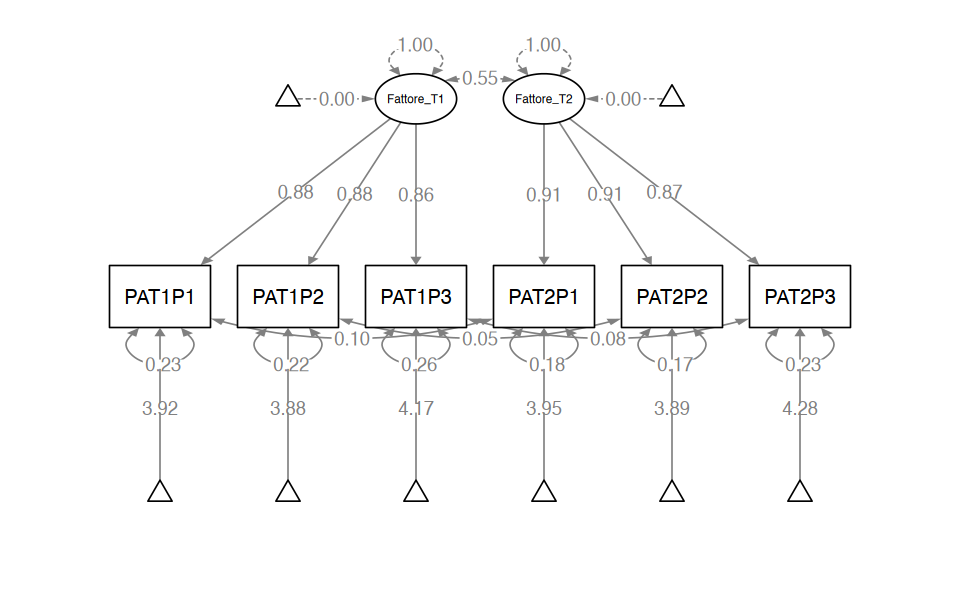

In [7]:
semPaths(fit_1,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 0.9,
    style = "mx",
    nCharNodes = 0, nCharEdges = 0
)

In [8]:
fitMeasures(fit_1, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
1.000 0.999 0.016 0.010 


Potremmo pensare che modello di baseline (con cui possono essere confrontati i modelli che descrivono il cambiamento temporale) sia semplicemente il modello in cui non sono permesse covarianze.

In [9]:
mod_2 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + PAT1P2 + PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + PAT2P2 + PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ 0*Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  # PAT1P1 ~~ PAT2P1
  # PAT1P2 ~~ PAT2P2
  # PAT1P3 ~~ PAT2P3

  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

In [10]:
fit_2 <- lavaan::sem(mod_2, data = dat, meanstructure = TRUE)

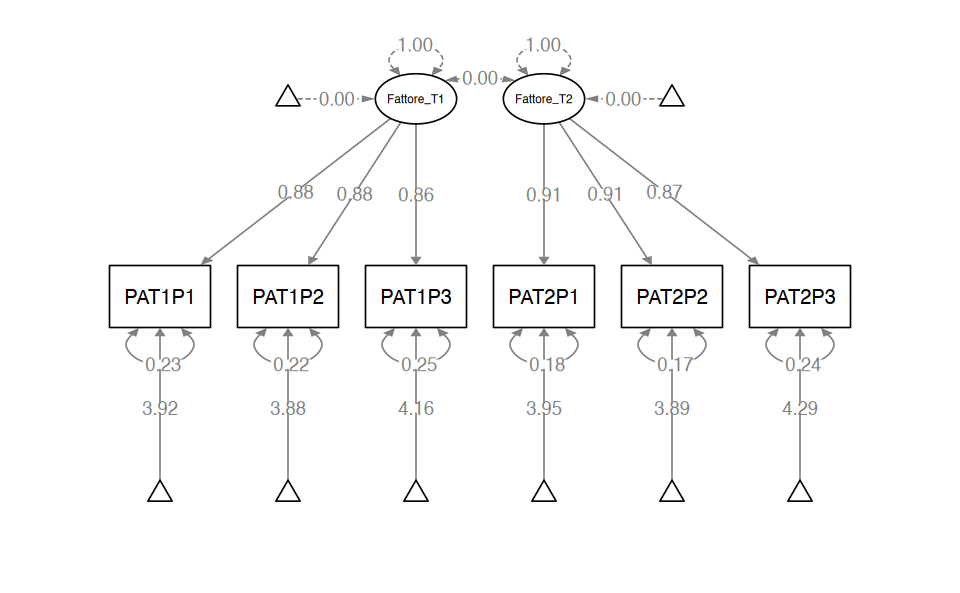

In [11]:
semPaths(fit_2,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 0.9,
    style = "mx",
    nCharNodes = 0, nCharEdges = 0
)

In [12]:
parameterEstimates(fit_2) |> print()

          lhs op        rhs   est    se       z pvalue ci.lower ci.upper
1  Fattore_T1 =~     PAT1P1 0.670 0.022  30.720      0    0.627    0.713
2  Fattore_T1 =~     PAT1P2 0.658 0.021  30.943      0    0.616    0.700
3  Fattore_T1 =~     PAT1P3 0.647 0.021  30.105      0    0.605    0.689
4  Fattore_T2 =~     PAT2P1 0.689 0.021  32.917      0    0.648    0.730
5  Fattore_T2 =~     PAT2P2 0.681 0.021  33.073      0    0.641    0.722
6  Fattore_T2 =~     PAT2P3 0.636 0.021  30.961      0    0.596    0.676
7  Fattore_T1 ~~ Fattore_T1 1.000 0.000      NA     NA    1.000    1.000
8  Fattore_T2 ~~ Fattore_T2 1.000 0.000      NA     NA    1.000    1.000
9  Fattore_T1 ~~ Fattore_T2 0.000 0.000      NA     NA    0.000    0.000
10     PAT1P1 ~~     PAT1P1 0.135 0.011  12.641      0    0.114    0.156
11     PAT1P2 ~~     PAT1P2 0.125 0.010  12.310      0    0.105    0.145
12     PAT1P3 ~~     PAT1P3 0.141 0.010  13.503      0    0.120    0.161
13     PAT2P1 ~~     PAT2P1 0.102 0.009  11.872    

In [17]:
fitMeasures(fit_2, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
0.931 0.886 0.187 0.253 


Tuttavia, @little2023longitudinal fa notare che, nel contesto dei disegni longitudinali, il modello di base adeguato prevede che vengano aggiunte al modello nullo delle aspettative aggiuntive, specificatamente che le medie e le varianze rimangano invariate nel tempo. Questa specificazione ampliata del modello nullo fornisce il confronto appropriato per analizzare e interpretare i dati longitudinali.

In [13]:
mod_3 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + b1*PAT1P2 + b2*PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + b1*PAT2P2 + b2*PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ c1*Fattore_T1
  Fattore_T2 ~~ c1*Fattore_T2

  # Covarianza tra i fattori latenti (assumendo che sia 0)
  Fattore_T1 ~~ 0*Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ a1*PAT1P1
  PAT1P2 ~~ a2*PAT1P2
  PAT1P3 ~~ a3*PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ a1*PAT2P1
  PAT2P2 ~~ a2*PAT2P2
  PAT2P3 ~~ a3*PAT2P3

  # Specifica delle medie degli indicatori (intercettazioni) uguali tra i due tempi
  # PAT1P1 ~ m1
  # PAT1P2 ~ m2
  # PAT1P3 ~ m3
  # PAT2P1 ~ m1
  # PAT2P2 ~ m2
  # PAT2P3 ~ m3
"

In [14]:
fit_3 <- lavaan::sem(mod_3, data = dat, meanstructure = TRUE)

Warning message:
"lavaan->lav_model_vcov():  
   The variance-covariance matrix of the estimated parameters (vcov) does 
   not appear to be positive definite! The smallest eigenvalue (= 
   4.086251e-17) is close to zero. This may be a symptom that the model 
   is not identified."


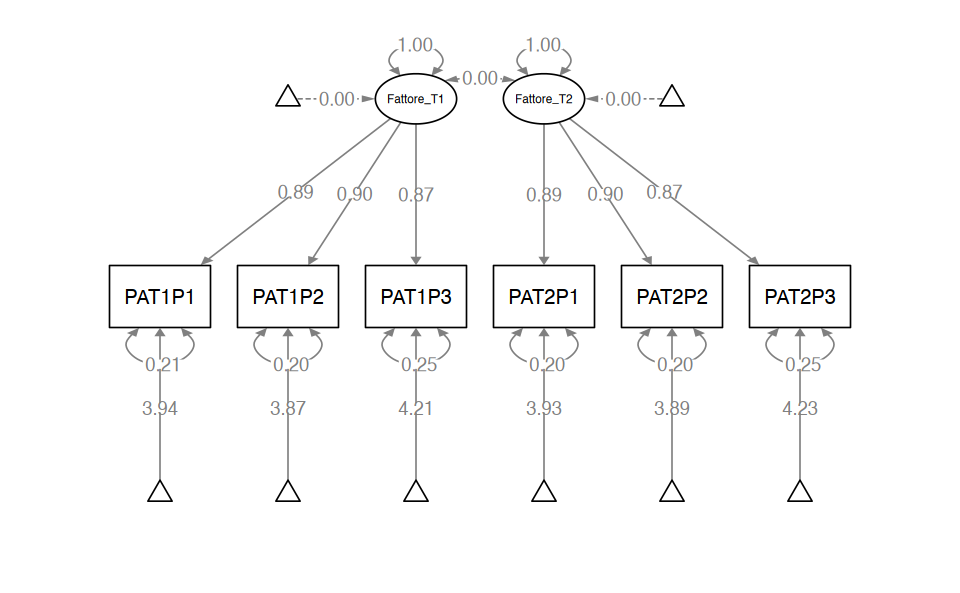

In [15]:
semPaths(fit_3,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 0.9,
    style = "mx",
    nCharNodes = 0, nCharEdges = 0
)

In [16]:
parameterEstimates(fit_3) |> print()

          lhs op        rhs label   est    se       z pvalue ci.lower
1  Fattore_T1 =~     PAT1P1       0.863 0.018  47.730      0    0.828
2  Fattore_T1 =~     PAT1P2    b1 0.854 0.012  71.968      0    0.831
3  Fattore_T1 =~     PAT1P3    b2 0.818 0.012  66.282      0    0.794
4  Fattore_T2 =~     PAT2P1       0.871 0.018  48.118      0    0.835
5  Fattore_T2 =~     PAT2P2    b1 0.854 0.012  71.968      0    0.831
6  Fattore_T2 =~     PAT2P3    b2 0.818 0.012  66.282      0    0.794
7  Fattore_T1 ~~ Fattore_T1    c1 0.614 0.014  44.667      0    0.587
8  Fattore_T2 ~~ Fattore_T2    c1 0.614 0.014  44.667      0    0.587
9  Fattore_T1 ~~ Fattore_T2       0.000 0.000      NA     NA    0.000
10     PAT1P1 ~~     PAT1P1    a1 0.119 0.007  17.380      0    0.105
11     PAT1P2 ~~     PAT1P2    a2 0.111 0.007  16.933      0    0.098
12     PAT1P3 ~~     PAT1P3    a3 0.134 0.007  19.941      0    0.121
13     PAT2P1 ~~     PAT2P1    a1 0.119 0.007  17.380      0    0.105
14     PAT2P2 ~~    

In [17]:
fitMeasures(fit_3, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
0.927 0.916 0.160 0.254 


Possiamo ora fare il confronto tra il modello di cambiamento latente e l'appropriato modello di confronto.

In [18]:
lavTestLRT(fit_1, fit_3) |> print()


Chi-Squared Difference Test

      Df    AIC    BIC    Chisq Chisq diff  RMSEA Df diff Pr(>Chisq)    
fit_1  5 7427.8 7531.4   6.0645                                         
fit_3 13 7693.5 7759.5 287.8078     281.74 0.2039       8  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


È evidente che, nel contesto di questi dati, un modello che presuma l'assenza di qualsiasi cambiamento è completamente inadeguato.